In [1]:
# import packages

import matplotlib.pyplot as plt
%matplotlib widget
import numpy as np
import pandas as pd
from scipy.interpolate import RegularGridInterpolator as rgridInter
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

In [2]:
def get_table_meta(file):
    
    # find list of tables to then splice table accordingly
    
    check = pd.read_csv(file, skiprows=60,nrows=1, delimiter='\\s+',header=None)
    n = check[4][0]      # num of tables in file
    
    table_check = pd.read_csv(file,skiprows=62, nrows=int(n), delimiter='\\s+', header=None)
    
    table_n = []
    X_n = []
    Y_n = []
    Z_n = []
    
    for i in table_check[2]:
        table_n.append(i)
    for i in table_check[5]:
        X_n.append(float(i.split('=')[1]))
    for i in table_check[6]:
        Y_n.append(float(i.split('=')[1]))
    for i in table_check[7]:
        Z_n.append(float(i.split('=')[1]))
    
    meta_data = {'Table': table_n, 'X': X_n, 'Y': Y_n, 'Z': Z_n}
    meta_table = pd.DataFrame(data=meta_data)
    
    return(meta_table)


def get_table(file,X,Y,Z):
    
    # return the specified opacity table in the file 
    
    meta_table = get_table_meta(file)
    meta_T = meta_table[(meta_table['X']==X) & (meta_table['Y']==Y) & (meta_table['Z']==Z)]
    for i in meta_T['Table']: n_i = int(i)
    skip_nums = (n_i*77)+168      # how tables are structured in file
    
    main_table = pd.DataFrame(pd.read_csv(file, skiprows=skip_nums, nrows=70, delimiter='\\s+'))
    
    return(main_table)

In [3]:
# star's properities
Mi = 2e33
Xi = 0.8
Yi = 0.12
Zi = 0.08


# constants
c = 2.99792458e10    # cm s^-1
a = 7.5646e-15     # erg cm^-3 K^-4
G = 6.67259e-8       # cm^3 g^-1 s^-2
N_A = 6.02214076e23    # mole^-1
k = 1.380658e-16    # cm^2 g s^-2 K^-1
R_sun = 6.96e10    # cm
sb = 5.67051e-5     # erg cm^-2 K^-4 s^-1


# opacity table
test1=get_table('GN93hz',Xi,Yi,Zi)

T_header = np.array(test1['logT'])
R_header = np.array(list(map(float,test1.columns[1:])))

data = np.array(test1.loc[:, test1.columns != 'logT'])      # table has weird structure and needs to be sliced

opacity_interp = rgridInter((T_header,R_header),data, bounds_error=False, fill_value=None)     # func to interpolate table based on logR and logT

In [4]:
def get_opacity(rho, T):
    
    # a func to interpolate the opacity table based on density and temperature
    
    logT = np.log10(T)
    T6 = T * 1e-6
    R = rho / T6**3      # defined as in opacity tables
    logR = np.log10(R)
    opacity = opacity_interp([logT,logR])
    
    return(opacity[0])


def calc_energy_gen(rho, T):
    
    # calculates the energy generation rate as sum of the rate for pp and cno cycles
    
    zeta = 1.     # correction factor, about unity
    X1 = Xi       # my X
    X_cno = 0.7 * Zi     # fraction of Z
    Z1 = 1.        # assuming unity for pp chain
    Z2 = 1.
    psi = 1.     # assuming unity
    
    T7 = T * 1e-7
    T9 = T * 1e-9
    
    f11 = np.exp(5.92e-3 * Z1*Z2 * (zeta * rho / T7**3)**(1/2))
    g11 = np.polyval([-0.0114,0.144,1.51,3.82,1],T9)
    g141 = np.polyval([-2.43,3.41,-2.00,1.00],T9)
    
    eps_pp = 2.57e4 * psi * f11 * g11 * rho * X1**2 * T9**(-2/3) * np.exp(-3.381/T9**(1/3))
    eps_cno = 8.24e25 * g141 * X_cno * X1 * rho * T9**(-2/3) * np.exp(-15.231*T9**(-1/3) - (T9/0.8)**2)
    
    return(eps_pp+eps_cno, [eps_pp,eps_cno])


def calc_density(P, T):
    
    # using equation of state, return rho
    
    mu = (2*Xi+(3./4.)*Yi+(1./2.)*Zi)**(-1)
    rho = mu*((P-(1./3.)*a*T**4)/(N_A*k*T))
    if rho <= 0:
        rho = 1e-6      # was having issues with zeros

    return(rho)


def calc_actual_del(m, l, P, T):
    
    # this calculates the actual gradient (minimum of adiabatic and radiative)
    
    rho = calc_density(P,T)
    opacity = 10**(get_opacity(rho,T))
    
    del_rad = (3./(16.*np.pi*a*c*G))*(P*opacity*l/(m*T**4))
    gamma2 = 5./3.                                           # assumption
    del_ad = (gamma2-1)/gamma2
    
    if del_rad < del_ad:
        act_del = del_rad
        del_type = 'radiative'
    elif del_rad >= del_ad or pd.isna(del_rad):
        act_del = del_ad
        del_type = 'adiabatic'
        
    return(act_del,del_type)


def load1(free_params):
    
    # this loads in boundary conditions at the center (small m)

    L_s, P_c, R_s, T_c = free_params
    
    rho_c = calc_density(P_c,T_c)
    
    eps_c, epss = calc_energy_gen(rho_c, T_c)
    
    m_0 = 1e-6          # away from 0
    l_c = eps_c*m_0
    del_c, del_type = calc_actual_del(m_0,l_c,P_c,T_c)
    
    opacity_c = get_opacity(rho_c,T_c)
    
    l = l_c
    P = P_c - ((3.*G/(8.*np.pi))*(4.*np.pi/3.*rho_c)**(4/3)*m_0**(2/3))
    r = ((3./(4.*np.pi*rho_c))*m_0)**(1/3)
    
    if del_type=='radiative':
        T = (T_c**4 - ((1./(2.*a*c))*(3./(4.*np.pi))**(2/3)*opacity_c*eps_c*rho_c**(4/3)*m_0**(2/3)))**(1/4)
    elif del_type=='adiabatic':
        T = np.exp(np.log(T_c) - ((np.pi/6.)**(1/3)*G*(del_c*rho_c**(4/3)/P_c)*m_0**(2/3)))
    
    return(l,P,r,T)


def eddington_grey_pressure(tau, P, free_params):
    
    # this is the enddington grey assumption describing T as a function of optical depth
    
    L_s, P_c, R_s, T_c = free_params
    
    T_edd = ((3./4.)*(L_s/(4.*np.pi*R_s**2*sb))*(tau+(2./3.)))**(1/4)
    # rho_s = Mi/((4./3.)*np.pi*R_s**3)
    rho_s = calc_density(P, T_edd)

    opacity_grey = get_opacity(rho_s, T_edd)
    
    dPdtau = G*Mi/(R_s**2*opacity_grey)
    
    return(dPdtau)


def load2(free_params):
    
    # this loads in the boundary conditions at the surface using Eddignton grey atmosphere approximation
    
    L_s, P_c, R_s, T_c = free_params
    
    rho_s = Mi/((4./3.)*np.pi*R_s**3)
    T_s = (L_s/(4.*np.pi*R_s**2*sb))**(1/4)

    sol_edd = solve_ivp(eddington_grey_pressure, [0,(2./3.)], [0], args=[free_params], t_eval=[2./3.])
    
    l = L_s
    P = sol_edd.y[0][0]
    r = R_s
    T = T_s
    
    return(l,P,r,T)


def derivs(m, dep_params):
    
    # these are the ODEs describing a star's structure
    
    l, P, r, T = dep_params
    
    rho = calc_density(P,T)
    
    tot_eps, epss = calc_energy_gen(rho, T)
    
    act_del, del_type = calc_actual_del(m,l,P,T)
    
    dldm = tot_eps
    dPdm = (-G*m)/(4.*np.pi*r**4)
    drdm = 1./(4.*np.pi*r**2*rho)
    dTdm = (-G*m*T)/(4.*np.pi*r**4*P)*act_del
    
    return(dldm,dPdm,drdm,dTdm)

In [5]:
def shootf(free_params, mf=None):
    
    # this function measures the residual between interior and exterior integration at mf
    
    lin, Pin, rin, Tin = load1(free_params)
    initial_in = [lin, Pin, rin, Tin]
    
    lex, Pex, rex, Tex = load2(free_params)
    initial_ex = [lex, Pex, rex, Tex]
    
    if mf is None:
        mf = Mi/2.
    
    sol_in = solve_ivp(derivs, [1e-6,mf], initial_in, t_eval=[mf])
    sol_ex = solve_ivp(derivs, [Mi,mf], initial_ex, t_eval=[mf])
    
    resid = abs(np.squeeze(sol_in.y) - np.squeeze(sol_ex.y))
    
    return(np.sum(resid))

In [6]:
guess_t=[2e33,2e11,7e10,1e7]

In [7]:
# minimize(shootf, guess_t)      # suppose to minimize residuals and hence return the best L_s,P_c,R_s,T_c
# however this is not converging!

In [ ]:
# example given free_params

free_par=[1e33,1e11,1e10,1e7]   # L_s, P_c, R_s, T_c

mft = (Mi/2.)

initial_in = load1(free_par)
initial_ex = load2(free_par)

sol_in = solve_ivp(derivs, [1e-6,mft], initial_in, dense_output=True)
sol_ex = solve_ivp(derivs, [Mi,mft], initial_ex, dense_output=True)

tin = np.linspace(1e-6, mft, 300)
tex = np.linspace(Mi, mft, 300)

zin = sol_in.sol(tin)
zex = sol_ex.sol(tex)

/Users/rangulo/programs/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_rgi.py:366: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xi = _ndim_coords_from_arrays(xi, ndim=ndim)
/var/folders/p0/v0qjg43n1wdbxq4_jwllzj140002tj/T/ipykernel_12546/3568887300.py:28: RuntimeWarning: invalid value encountered in double_scalars
  f11 = np.exp(5.92e-3 * Z1*Z2 * (zeta * rho / T7**3)**(1/2))
/var/folders/p0/v0qjg43n1wdbxq4_jwllzj140002tj/T/ipykernel_12546/3568887300.py:32: RuntimeWarning: invalid value encountered in double_scalars
  eps_pp = 2.57e4 * psi * f11 * g11 * rho * X1**2 * T9**(-2/3) * np.exp(-3.381/T9**(1/3))
/var/folders/p0/v0qjg43n1wdbxq4_jwllzj140002tj/T/ipykernel_12546/3568887300.py:33: RuntimeWarning: invalid value encountered in double_scalars
  eps_cno = 8

[Text(0, 0.5, 'Temperature'), Text(0.5, 0, 'm')]

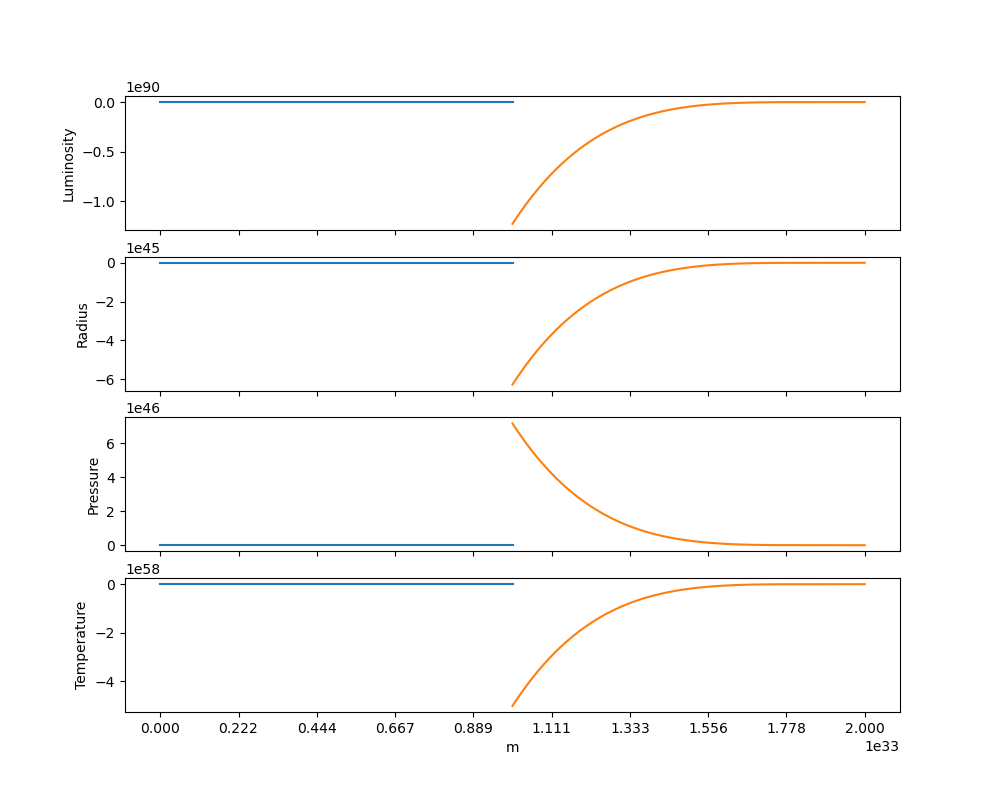

In [ ]:
# plot the params vs mass

fig = plt.figure(dpi = 100, figsize = [10,8])
gs = fig.add_gridspec(4, hspace=0.2)
axs = gs.subplots(sharex=True)

for ax in axs.flat:
    ax.set(xticks=np.linspace(1e-6, Mi, 10))

axs[0].plot(tin, zin[0])
axs[0].plot(tex, zex[0])
axs[0].set(ylabel='Luminosity')

axs[1].plot(tin, zin[1])
axs[1].plot(tex, zex[1])
axs[1].set(ylabel='Radius')

axs[2].plot(tin, zin[2])
axs[2].plot(tex, zex[2])
axs[2].set(ylabel='Pressure')

axs[3].plot(tin, zin[3])
axs[3].plot(tex, zex[3])
axs[3].set(ylabel='Temperature', xlabel='m')